In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
df=pd.read_csv("../data/engineered_retail_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
features = [
    'product_id',
    'product_mean', 'product_std', 'product_median',
    'cat_mean', 'brand_mean', 'type_mean',
    'country_mean', 'state_mean',
    'Month', 'DayOfWeek', 'Quarter',
    'lag_1','lag_7','lag_14','lag_30',
    'roll_7_mean','roll_30_mean','roll_30_std'
]


target = 'Total_Purchases'


In [4]:
df = df.sort_values(['product_id', 'Date']).reset_index(drop=True)

In [5]:
train = df[df['Date'] < '2024-01-01']
test  = df[df['Date'] >= '2024-01-01']


In [6]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [7]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


In [8]:
preds = model.predict(X_test)


In [9]:
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    median_absolute_error
)
import numpy as np

# ---- Existing Metrics ----
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

# ---- Additional Metrics ----
# MAPE (avoid divide by zero)
mape = np.mean(np.abs((y_test - preds) / (y_test + 1e-8))) * 100

# SMAPE
smape = 100 * np.mean(
    2 * np.abs(y_test - preds) / (np.abs(y_test) + np.abs(preds) + 1e-8)
)

# R2 Score
r2 = r2_score(y_test, preds)

# Median Absolute Error
medae = median_absolute_error(y_test, preds)

# RMSLE
rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(preds)))

# Print all metrics
print("XGBRegressor Test MAE:", mae)
print("XGBRegressor Test RMSE:", rmse)
print("XGBRegressor Test MAPE:", mape)
print("XGBRegressor Test SMAPE:", smape)
print("XGBRegressor Test R²:", r2)
print("XGBRegressor Test Median AE:", medae)
print("XGBRegressor Test RMSLE:", rmsle)




XGBRegressor Test MAE: 2.241167025343182
XGBRegressor Test RMSE: 2.666910552941462
XGBRegressor Test MAPE: 79.35132333130977
XGBRegressor Test SMAPE: 47.710596914984585
XGBRegressor Test R²: 0.14138841277942082
XGBRegressor Test Median AE: 2.094179153442383
XGBRegressor Test RMSLE: 0.504466657981657


In [10]:
test['preds'] = preds


daily_actual = test.groupby('Date')['Total_Purchases'].sum()
daily_pred   = test.groupby('Date')['preds'].sum()



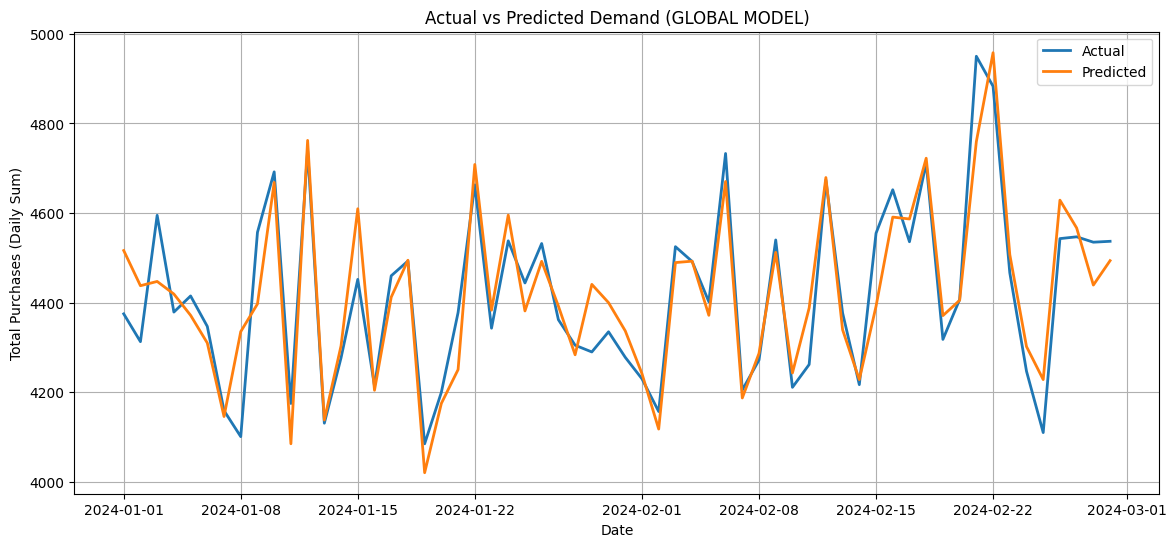

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(daily_actual.index, daily_actual.values, label='Actual', linewidth=2)
plt.plot(daily_pred.index,   daily_pred.values,   label='Predicted', linewidth=2)
plt.title("Actual vs Predicted Demand (GLOBAL MODEL)")
plt.xlabel("Date")
plt.ylabel("Total Purchases (Daily Sum)")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
from lightgbm import LGBMRegressor

In [13]:
model = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.3,
    reg_lambda=0.3,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1379
[LightGBM] [Info] Number of data points in the train set: 241073, number of used features: 19
[LightGBM] [Info] Start training from score 5.362679


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.03
,n_estimators,800
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [14]:
preds = model.predict(X_test)


In [15]:
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    median_absolute_error
)
import numpy as np

# ---- Existing Metrics ----
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

# ---- Additional Metrics ----
# MAPE (avoid divide by zero)
mape = np.mean(np.abs((y_test - preds) / (y_test + 1e-8))) * 100

# SMAPE
smape = 100 * np.mean(
    2 * np.abs(y_test - preds) / (np.abs(y_test) + np.abs(preds) + 1e-8)
)

# R2 Score
r2 = r2_score(y_test, preds)

# Median Absolute Error
medae = median_absolute_error(y_test, preds)

# RMSLE
rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(preds)))

# Print all metrics
print("LightGBM Test MAE:", mae)
print("LightGBM Test RMSE:", rmse)
print("LightGBM Test MAPE:", mape)
print("LightGBM Test SMAPE:", smape)
print("LightGBM Test R²:", r2)
print("LightGBM Test Median AE:", medae)
print("LightGBM Test RMSLE:", rmsle)


LightGBM Test MAE: 2.221271096380299
LightGBM Test RMSE: 2.6312859465825236
LightGBM Test MAPE: 79.00761795437758
LightGBM Test SMAPE: 47.412218293765754
LightGBM Test R²: 0.1641738822375467
LightGBM Test Median AE: 2.095377553532009
LightGBM Test RMSLE: 0.4998193627835236


In [16]:
test["preds"] = preds

daily_actual = test.groupby("Date")["Total_Purchases"].sum()
daily_pred   = test.groupby("Date")["preds"].sum()


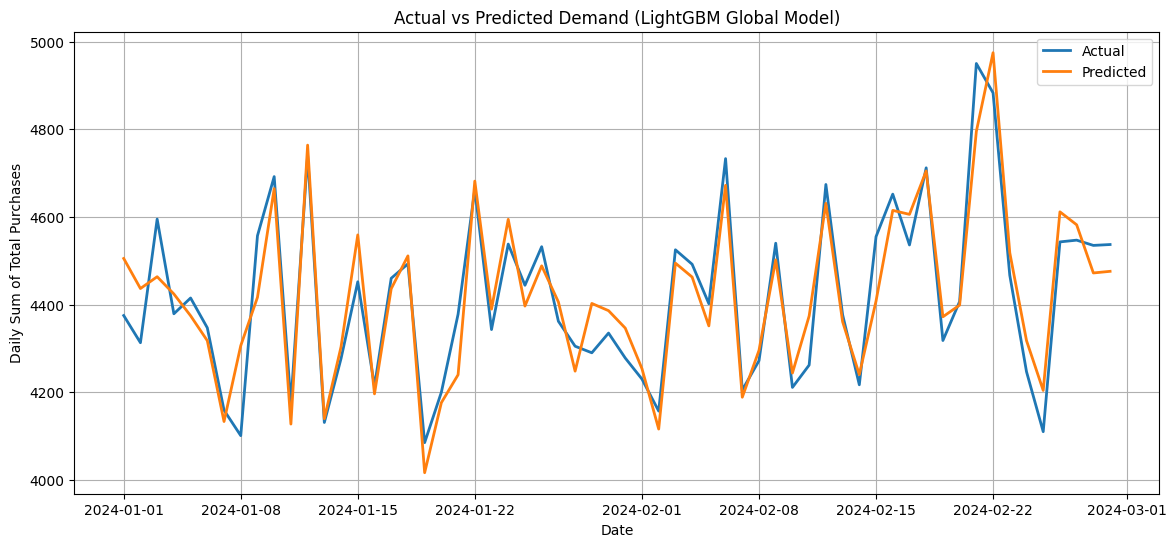

In [17]:
plt.figure(figsize=(14,6))
plt.plot(daily_actual.index, daily_actual.values, label="Actual", linewidth=2)
plt.plot(daily_pred.index, daily_pred.values, label="Predicted", linewidth=2)
plt.title("Actual vs Predicted Demand (LightGBM Global Model)")
plt.xlabel("Date")
plt.ylabel("Daily Sum of Total Purchases")
plt.legend()
plt.grid(True)
plt.show()
